In [1]:
import pandas as pd
import random
import os
import numpy as np
import torch
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from torch.nn.modules.loss import _WeightedLoss
from torch import nn
from torch import optim
import torch.nn.functional as F
from sklearn.metrics import log_loss
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA

In [2]:
#read data-set

train_features = pd.read_csv('..\\dataset\\train_features.csv')
test_features = pd.read_csv('..\\dataset\\test_features.csv')
train_targets_scored = pd.read_csv('..\\dataset\\train_targets_scored.csv')
sample_submission = pd.read_csv('..\\dataset\\sample_submission.csv')

GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]


In [3]:
for col in (GENES + CELLS):

    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# PCA features

In [5]:
# GENES
n_comp_GENES = 450
n_comp_CELLS = 45
VarianceThreshold_for_FS = 0.67

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp_GENES, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])

train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [6]:
data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp_CELLS, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])

train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [7]:
# create train-set, test-set and targets
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

target_cols = target.drop('sig_id', axis=1).columns.values.tolist()


In [8]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

def plot_labels(x_dict): 
    x = {k: v for k, v in sorted(x_dict.items(), key=lambda item: item[1], reverse=True)}
    keys = x.keys()
    vals = x.values()

    font = {'family': 'serif',
            'color':  'green',
            'weight': 'normal',
            'size': 16,
            }
    fig, ax = plt.subplots(figsize=(35, 10))
    plt.bar(keys, vals)
    plt.title('MoA Scored Labels ',fontdict=font)
    plt.ylabel ('Counts')
    plt.xlabel ('Labels')
    plt.xticks(list(keys))
    # plt.
    plt.show()

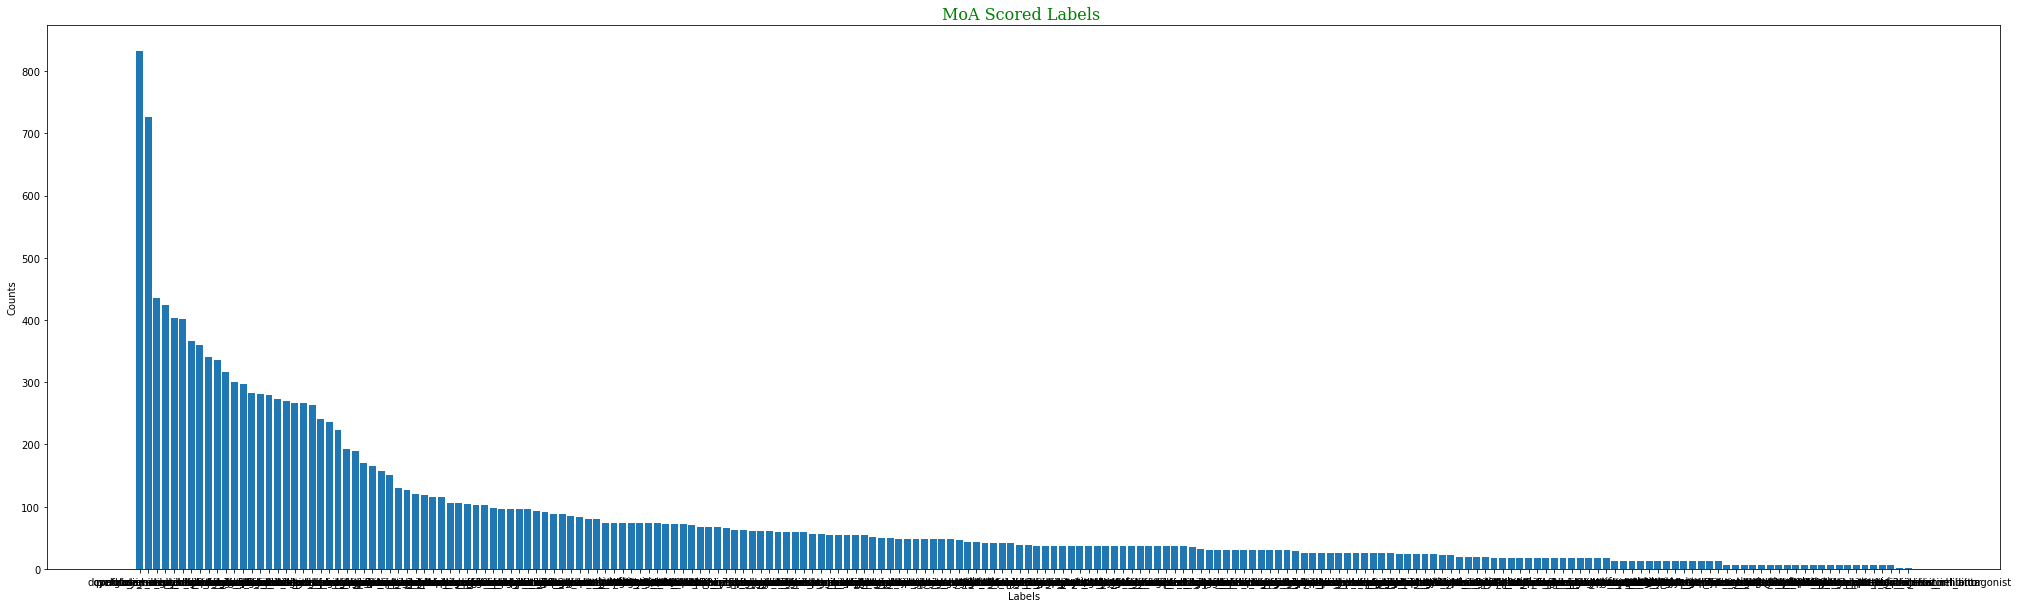

0.5


In [9]:
plot_labels(train_targets_scored[target_cols].sum().to_dict())
s = train_targets_scored[target_cols].sum()
maxs = max(s)
s = s / maxs
s = s.to_list()
out_w = [1.5 - s for s in s]
# out_w = [1 - s*0.5 for s in s]
print(min(out_w))

In [10]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=7)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

C:\Users\adryy\anaconda3\envs\n2hack2020\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


sig_id  cp_time cp_dose       g-0       g-1       g-2       g-3  \
0      id_000644bb2       24      D1  1.134849  0.907687 -0.416385 -0.966814   
1      id_000779bfc       72      D1  0.119282  0.681738  0.272399  0.080113   
2      id_000a6266a       48      D1  0.779973  0.946463  1.425350 -0.132928   
3      id_0015fd391       48      D1 -0.734910 -0.274641 -0.438509  0.759097   
4      id_001626bd3       72      D2 -0.452718 -0.477513  0.972316  0.970731   
...             ...      ...     ...       ...       ...       ...       ...   
21943  id_fff8c2444       72      D1  0.237856 -1.228203  0.218376 -0.365976   
21944  id_fffb1ceed       24      D2  0.209361 -0.022389 -0.235888 -0.796989   
21945  id_fffb70c0c       24      D2 -1.911021  0.587228 -0.588417  1.296405   
21946  id_fffcb9e7c       24      D1  0.816407  0.417618  0.431631  0.300617   
21947  id_ffffdd77b       72      D1 -1.243096  1.567730 -0.269573  1.083636   

            g-4       g-5       g-6  ...  trpv_agonist  trpv_antagonist  \
0     -0.254723 -1.017473 -1.364787  ...             0                0   
1      1.205169  0.686517  0.313396  ...             0                0   
2     -0.006122  1.492493  0.235577  ...             0                0   
3      2.346330 -0.858153 -2.288417  ...             0                0   
4      1.463427 -0.869555 -0.375501  ...             0                0   
...         ...       ...       ...  ...           ...              ...   
21943 -0.330177  0.569243 -0.150978  ...             0                0   
21944 -0.674009  0.919312  0.735603  ...             0                0   
21945 -1.002640  0.850589 -0.304313  ...             0                0   
21946  1.070346 -0.024189  0.048942  ...             0                0   
21947 -0.511235 -2.099634 -1.622462  ...             0                0   

       tubulin_inhibitor  tyrosine_kinase_inhibitor  \
0                      0                          0   
1                      0                          0   
2                      0                          0   
3                      0                          0   
4                      0                          0   
...                  ...                        ...   
21943                  0                          0   
21944                  0                          0   
21945                  0                          0   
21946                  0                          0   
21947                  0                          0   

       ubiquitin_specific_protease_inhibitor  vegfr_inhibitor  vitamin_b  \
0                                          0                0          0   
1                                          0                0          0   
2                                          0                0          0   
3                                          0                0          0   
4                                          0                0          0   
...                                      ...              ...        ...   
21943                                      0                0          0   
21944                                      0                0          0   
21945                                      0                0          0   
21946                                      0                0          0   
21947                                      0                0          0   

       vitamin_d_receptor_agonist  wnt_inhibitor  kfold  
0                               0              0      5  
1                               0              0      0  
2                               0              0      6  
3                               0              0      0  
4                               0              0      4  
...                           ...            ...    ...  
21943                           0              0      5  
21944                           0              0      1  
21945                           0              0      5

In [11]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

In [12]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds


In [13]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

# Preprocessing

In [14]:
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

feature_cols = [c for c in process_data(folds).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
len(feature_cols)

1372

# Modeling

In [15]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 30
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 7
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=num_targets*4
lstm_size=num_targets*4

DEVICE

'cuda'

In [16]:
out_w = torch.cuda.FloatTensor(out_w)
a=torch.cuda.FloatTensor()
len(feature_cols)

1372

In [17]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        
        self.lstm1 = nn.GRU(num_features, lstm_size, num_layers=2, dropout=0.25, bidirectional=True)

        
        self.batch_norm1 = nn.BatchNorm1d(lstm_size*2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(lstm_size*2, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.25) # Update
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, int(hidden_size/2)))
        
        self.batch_norm3 = nn.BatchNorm1d(int(hidden_size/2))
        self.dropout3 = nn.Dropout(0.25) # Update
        self.dense3 = nn.utils.weight_norm(nn.Linear(int(hidden_size/2), num_targets))
    
    def forward(self, inp):
        
        lstm_out, _ = self.lstm1(inp.view(len(inp), 1, -1))
        
        
        x = self.batch_norm1(lstm_out.view(len(inp), -1))
        x = F.leaky_relu(self.dense1(lstm_out.view(len(inp), -1)))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))   

# # Run training

In [33]:
from torchsummary import summary

def run_training(fold, seed):
    
    seed_everything(seed)
    
    train = process_data(folds)
    test_ = process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    
    model.to(DEVICE)
    
    summary(model, input_size=(1,num_features))
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = SmoothBCEwLogits(smoothing =0.001, weight=out_w)
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
   
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    #vis_tr = Visualizations()
    #vis_val = Visualizations
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        #vis_tr.plot_loss(train_loss, step=epoch)
        #vis_val.plot_loss(valid_loss, step=epoch)
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,

    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

In [34]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [ ]:
SEED = [122] # [0, 1, 2, 3, 4, 5, 6]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

for seed in SEED:
    
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

train[target_cols] = oof
test[target_cols] = predictions

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 1, 1648], [-1, 1, 824]]               0
       BatchNorm1d-2                 [-1, 1648]           3,296
            Linear-3                  [-1, 824]       1,358,776
       BatchNorm1d-4                  [-1, 824]           1,648
           Dropout-5                  [-1, 824]               0
            Linear-6                  [-1, 412]         339,900
       BatchNorm1d-7                  [-1, 412]             824
           Dropout-8                  [-1, 412]               0
            Linear-9                  [-1, 206]          85,078
Total params: 1,789,522
Trainable params: 1,789,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 10.32
Params size (MB): 6.83
Estimated Total Size (MB): 17.15
---------------------------------

# Submission

In [ ]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)  

In [ ]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission' + str(score) + '.csv', index=False)